In [232]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.signal as signal
from math import log10

**SE OBTIENE LA SEÑAL**




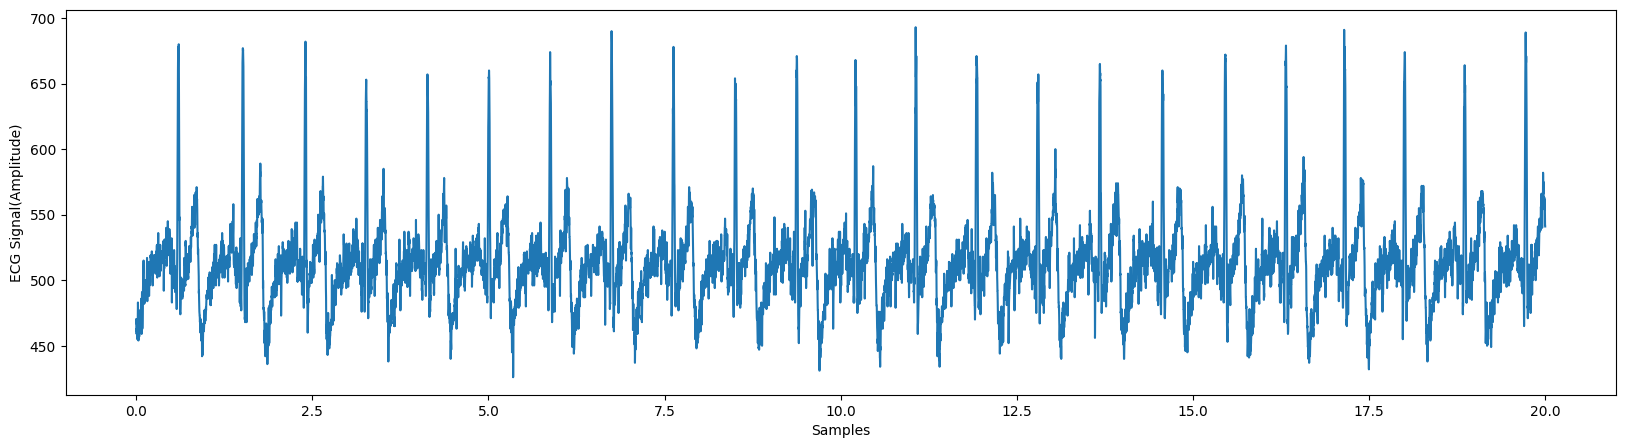

In [216]:
# A numpy
sensor = np.genfromtxt('Basal 1' + ".txt", delimiter="\t")
sensor = sensor[:,-2][:20000]
t = np.arange(len(sensor))/1000
plt.figure(figsize=(20,5))
plt.plot(t, sensor)
plt.ylabel('ECG Signal(Amplitude)')
plt.xlabel('Time (s)')
plt.show()

**SE ANALIZA LA SEÑAL EN FRECUENCIA**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

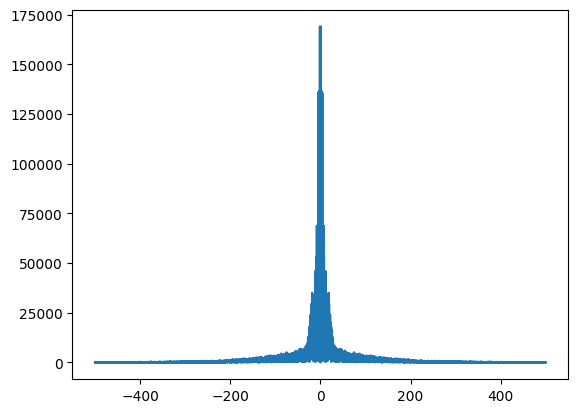

In [217]:
#Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as ft

def fft(x,fs):
    X = ft.fftshift(ft.fft(x))
    N = len(x)
    k = np.arange(N)
    w = 2*np.pi*k/N
    w = ft.fftshift(w)
    w = np.unwrap(w - 2*np.pi)
    f = w*fs/(2*np.pi)
    return X,f,w
fs = 1000
ecg_signal = sensor
E,f,w = fft(sensor,fs)
E[f == 0] = 0 # eliminamos el DC
plt.figure(2)
plt.plot(f,abs(E))

En el gráfico anterior, no existe un ruido en 50 Hz. Pero vamos a hacer un filtro pasa banda para mejorar la señal de interes.

**FILTRADO DE PASA BANDA**

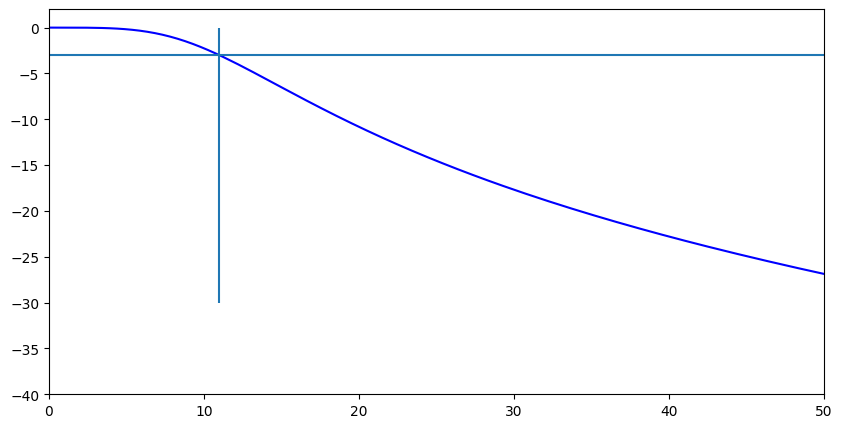

In [218]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks, lfilter
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

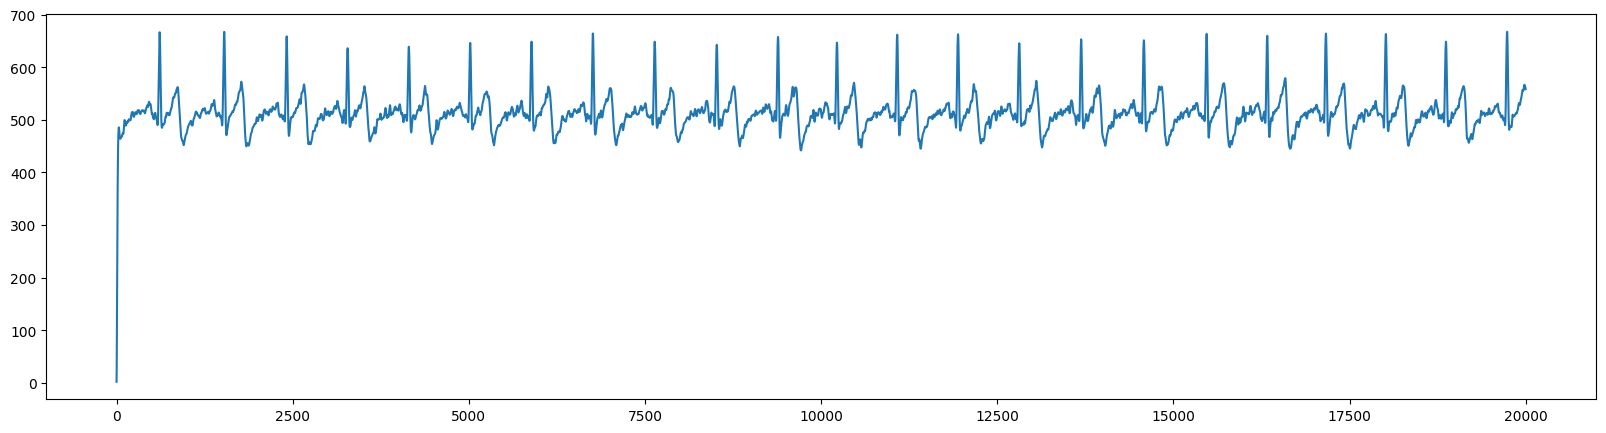

In [219]:
fpb_signal = lfilter(b, a, ecg_signal)
plt.figure(figsize=(20,5))
plt.plot(fpb_signal)
plt.show()

**FILTRO PASA ALTO**

C:\Users\LUIS BARRETO\AppData\Local\Temp\ipykernel_20348\3387080172.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


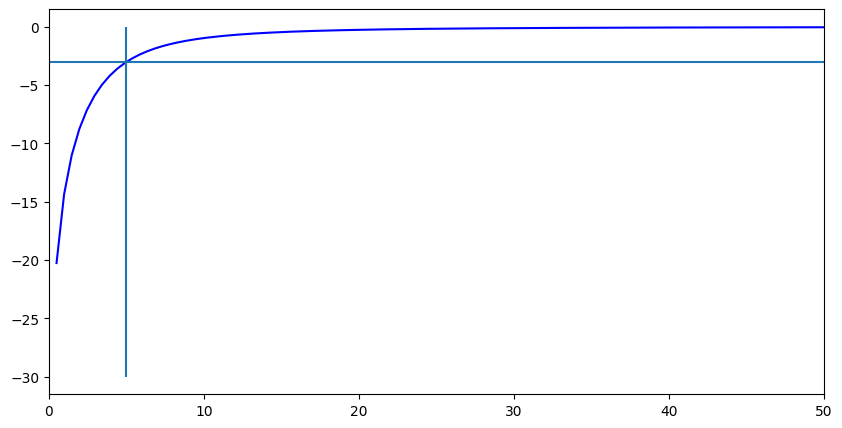

In [220]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()


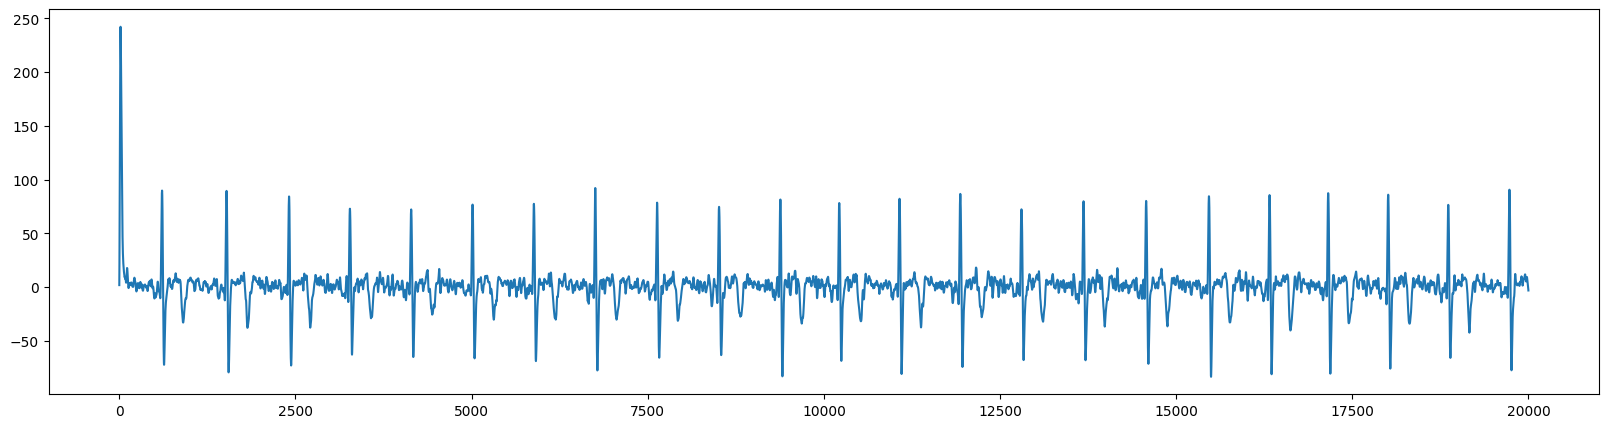

In [221]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(fpa_signal)
plt.show()

**OPERADOR DERIVATIVO**

En el artículo nos dan la siguiente función que describe al operador:

y[n]=(1/8)(−x[n−2]−2x[n−1]+2x[n+1]+x[n+2])

Para que esta ecuación pueda ser utilizada necesitamos encuadrarla en un rango de  [0,+∞]  haciendo que  n=+2  entonces tenemos:

y[n]=(1/8)(−x[n]−2x[n+1]+2x[n+3]+x[n+4]) 

Por lo tanto:

b=[−1,−2,0,2,1]

C:\Users\LUIS BARRETO\AppData\Local\Temp\ipykernel_20348\73101146.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


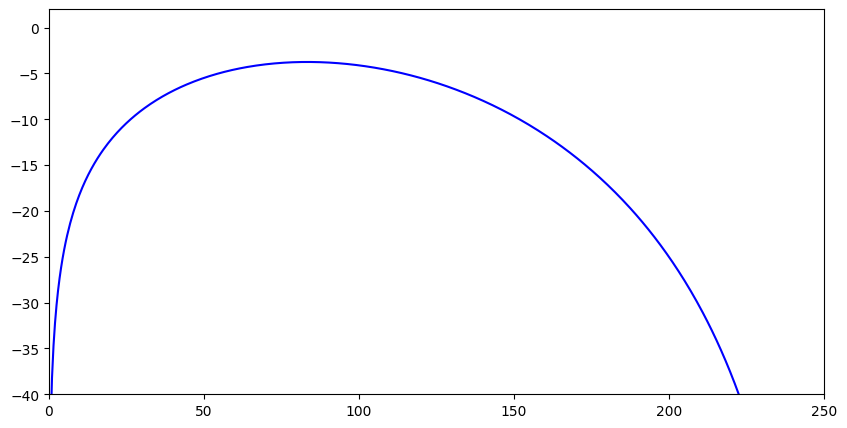

In [222]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

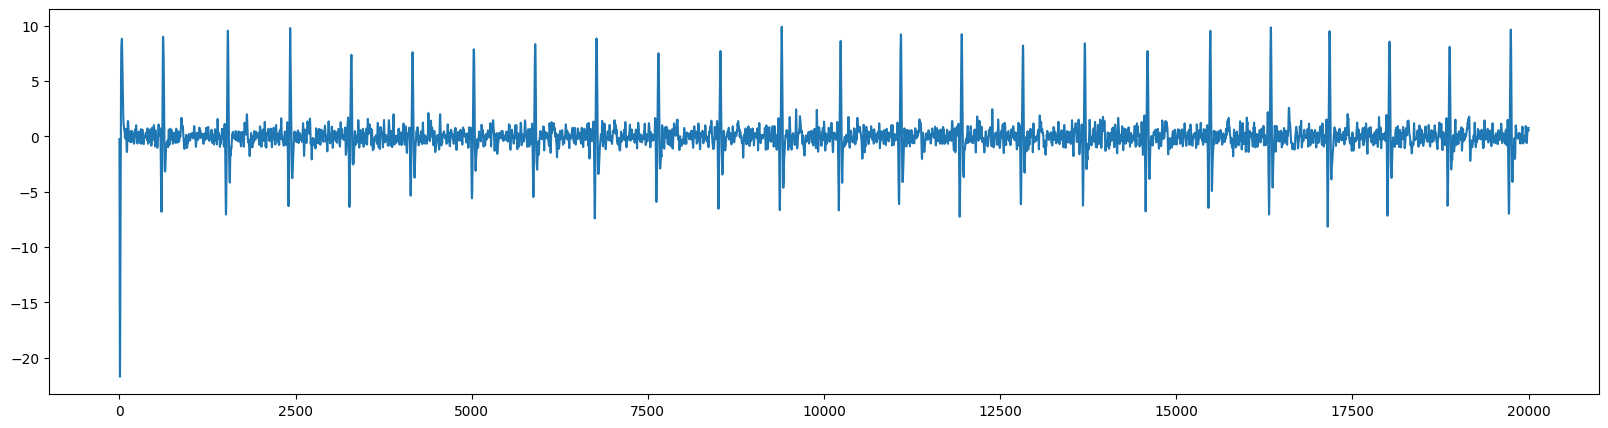

In [223]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(fd_signal)
plt.show()

**OPERADOR CUADRÁTICO**

Este operador solo tiene como función elevar al cuadrado los valores de la señal.

y[n]=x^2[n]

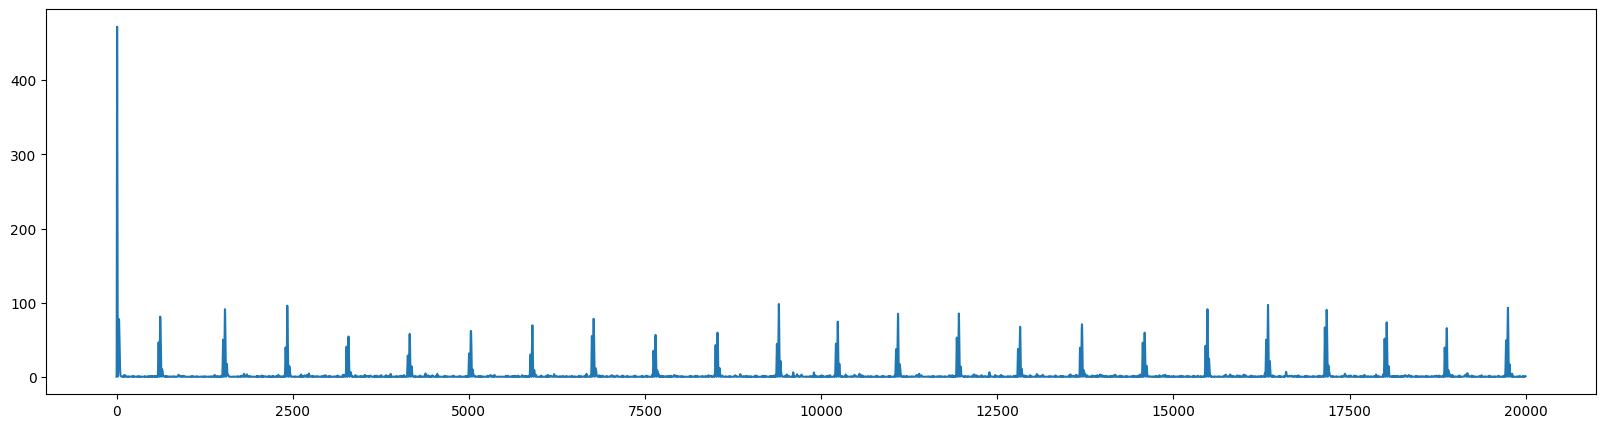

In [224]:
# Filtro cuadrado
f_sq = np.square(fd_signal)
plt.figure(figsize=(20,5))
plt.plot(f_sq)
plt.show()

**OPERADOR MOVING WINDOW INTEGRATION**

Este operador tiene como función extraer ciertas características de la onda.

y[n]=(1/N)(x[n−(N−1)]+x[n−(N−2)]+..+x[n])

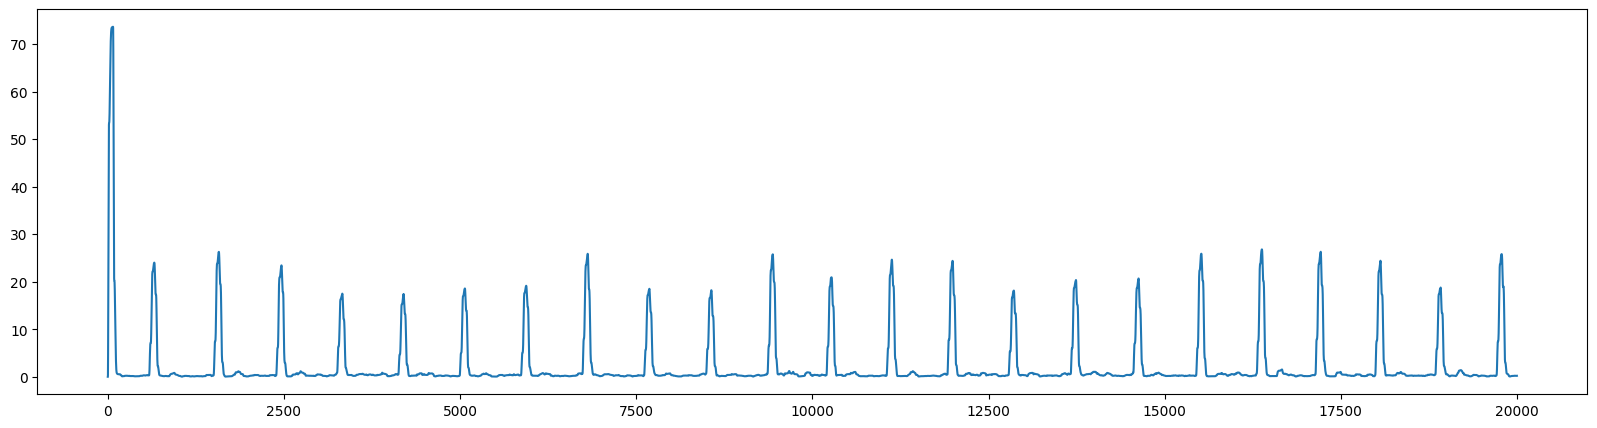

In [225]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.show()

Colocando marcadores en los picos

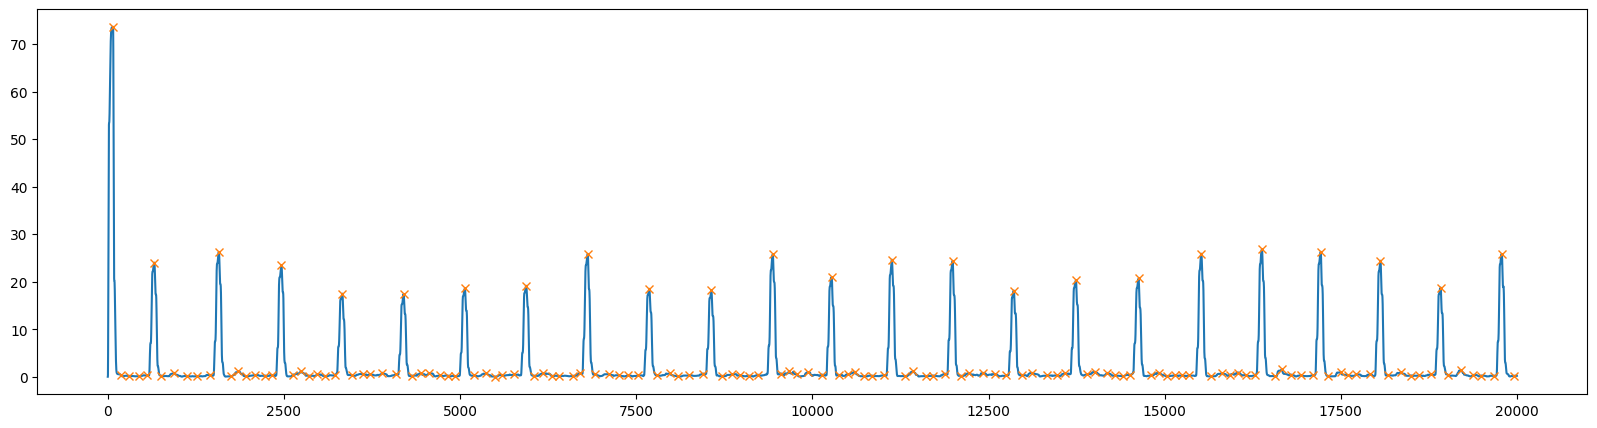

In [226]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=100)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

**ANÁLISIS DE THRESHOLD**

El valor del umbral de pico R de entrada es  18.419991412059787
El valor del umbral de ruido de entrada es  2.189029166806574


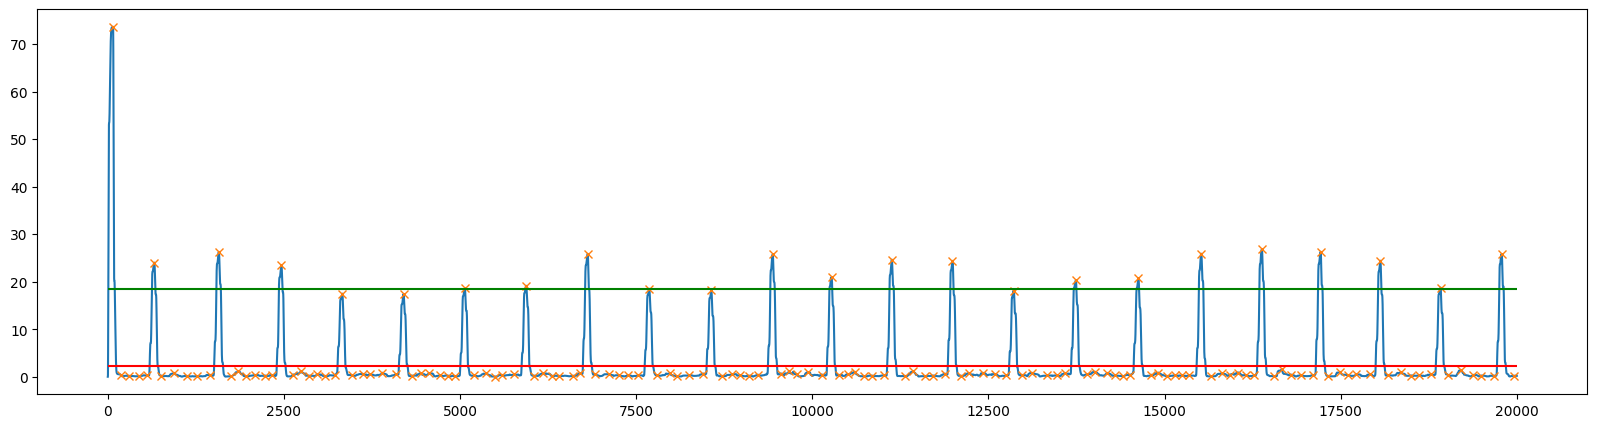

In [227]:
# Training Part to set Threshold I1 and Threshold I2
# Para las primeras muestras en 2 segundos
# Para efectos del ejercicio vamos a analizar toda la señal
f_samples = len(peaks)
th_I1 = np.max(fi_signal[peaks[:f_samples]])*0.25
th_I2 = 0.5*np.mean(fi_signal[peaks[:f_samples]])
print ("El valor del umbral de pico R de entrada es ", th_I1)
print ("El valor del umbral de ruido de entrada es ", th_I2)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
#plt.xlim(50,1000)
plt.plot(peaks, fi_signal[peaks], "x")
plt.hlines(th_I1, 0, len(fi_signal), colors='green')
plt.hlines(th_I2, 0, len(fi_signal), colors='red')
plt.show()

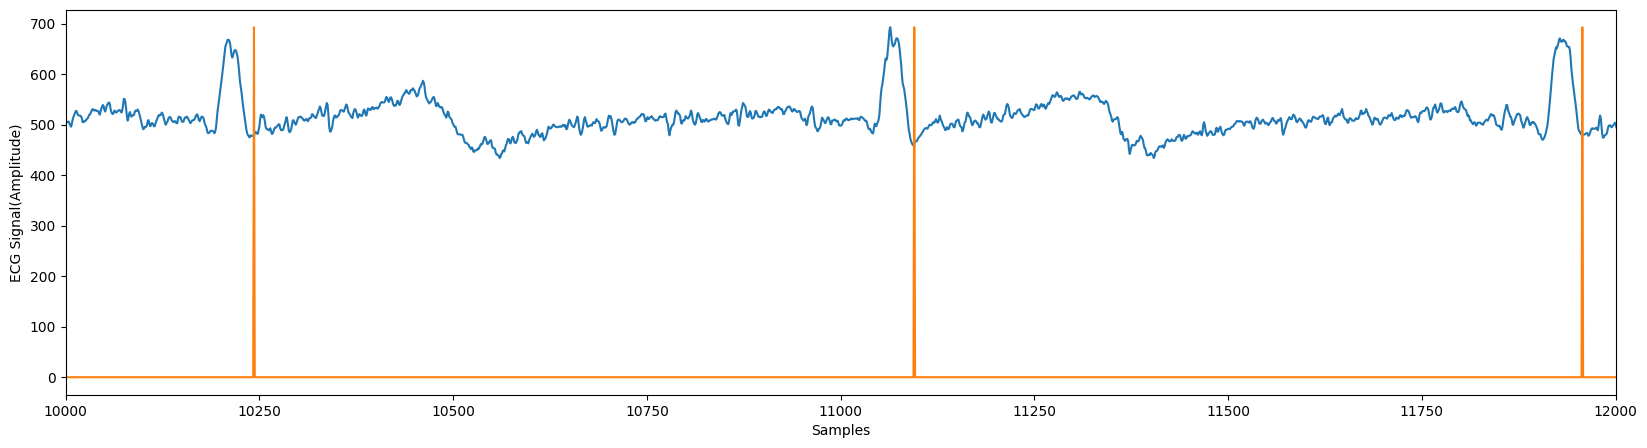

In [228]:
end_qrs = fi_signal > th_I1
roll_qrs_r = np.roll(end_qrs, 1)
roll_qrs_l = np.roll(end_qrs, -1)
end_qrs = np.logical_xor(end_qrs ,roll_qrs_r)
end_qrs = np.logical_and(end_qrs ,roll_qrs_l)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.xlim(10000,12000)
plt.ylabel('ECG Signal(Amplitude)')
plt.xlabel('Samples')
plt.plot(end_qrs*np.max(ecg_signal))
plt.show()

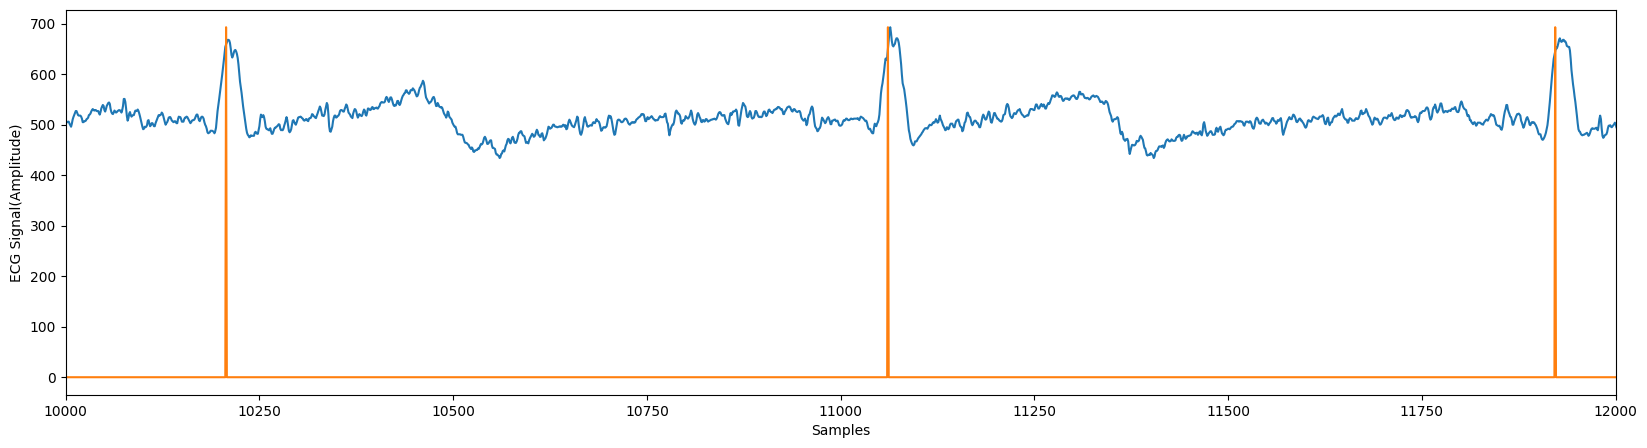

In [229]:
start_qrs = fi_signal < th_I2
roll_qrs_l = np.roll(start_qrs, -1)
roll_qrs_r = np.roll(start_qrs, 1)
start_qrs = np.logical_xor(start_qrs ,roll_qrs_l)
start_qrs = np.logical_and(start_qrs ,roll_qrs_r)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.xlim(10000,12000)
plt.ylabel('ECG Signal(Amplitude)')
plt.xlabel('Samples')
plt.plot(start_qrs*np.max(ecg_signal))
plt.show()

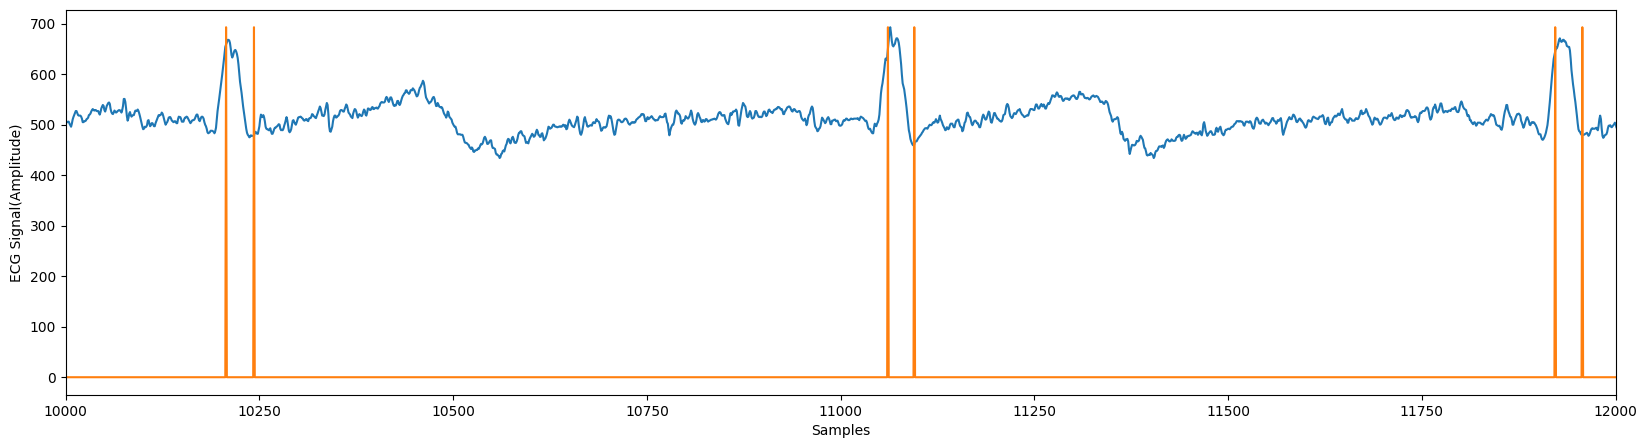

In [230]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.xlim(10000,12000)
plt.ylabel('ECG Signal(Amplitude)')
plt.xlabel('Samples')
plt.plot(qrs*np.max(ecg_signal))
plt.show()


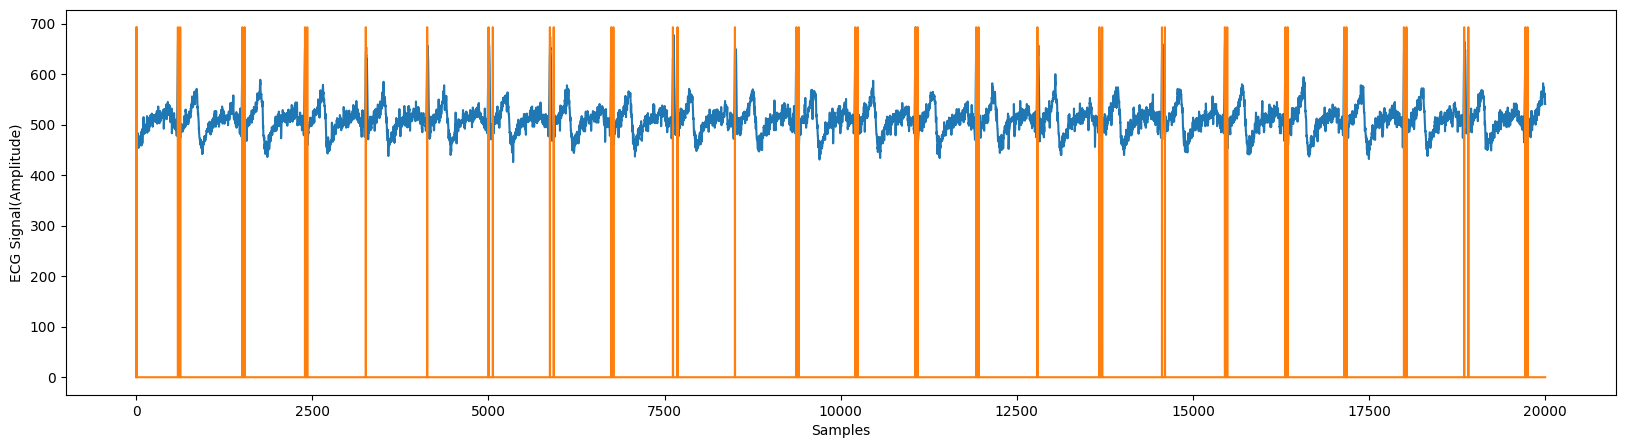

In [231]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.ylabel('ECG Signal(Amplitude)')
plt.xlabel('Samples')
plt.show()